# Evaluation and Multi-Layer Perceptron: 2009 American Community Survey

### Nick Chao

### Preparation (15 points total)

[5 points] (mostly the same processes as from previous lab) Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the task is and what parties would be interested in the results. How well would your prediction algorithm need to perform to be considered useful by interested parties?
[10 points] (mostly the same processes as from lab one) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification (include a description of any newly formed variables you created).


### Evaluation (30 points total)

[15 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s generalization performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why does the metric evaluate performance in terms of the business case you argued for. Please note: rarely is accuracy the best evaluation metric to use. 
Think deeply about an appropriate measure of performance.

[15 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time. Convince the reader that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

Important: You should use your chosen evaluation criteria and chosen method for dividing train/test data throughout the report. For example, arguing that f-score is the best evaluation method, but then using accuracy in a grid search will be regarded as a conceptual error and graded accordingly. 


### Modeling (45 points total)

[20 points] Create a custom implementation of the multi-layer perceptron. Start with the implementation given to you in the course. Update the MLP class to:
    When instantiated, use a selectable phi function for the initial layer: either sigmoid or linear 
    Use a selectable cost function when instantiated: either quadratic or cross entropy
    Add support for any number of hidden layers (user customizable).

[15 points] Tune the hyper-parameters of your MLP model (phi function, objective function, and number of layers). While tuning hyper-parameters, analyze the results using your chosen metric(s) of evaluation. Visualize the evaluation metric(s) versus the hyper-parameters. Conclude what combination of parameters are best.

[10 points] Visualize the magnitude of the gradients in each layer of the neural network versus the training iteration. Do the gradients stay consistent in each layer?

### Exceptional Work (10 points total)

You have free reign to provide additional analyses.
One idea (required for 7000 level students):  Implement two more phi functions: ReLU and SiLU (also called Swish). Compare their performance to the linear and sigmoid phi functions. 


## Data Overview

In this lab, we investigate possible relationships between an individual's income and attributes about them. The data used in this lab is provided by the 2009 American Community Survey 1-Year PUMS Population File which can be found here. https://catalog.data.gov/dataset/2009-american-community-survey-1-year-pums-population-file. This dataset contains more than 3 million entries and nearly 300 attributes. To make sense of some of these attributes, there is a dictionary lookup that provides more information about the columns. You can find this reference here. https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMSDataDict09.pdf.

To be more specific, we want to see if we can predict a person's current income based on factors about themselves that they might give away when applying for a new job. For example, their age, sex, education level, and more are just a few peices of information that companies may ask for when applying for a new job. 

This information could be incrediably useful for a company that is hiring new personal. If they know the current income of someone who has applied for a job at their company, then they can offer the lowest starting salary they believe the new canadate will accept. (i.e. slightly above what they currently make). 

Since my overall goal is considered difficult as it is to accurately determine a person's income, I've decided that I will try to determine a person's income bracket instead. This is a good starting point as there are much less classes to predict. Initially I will start with 5 income brackets. Although this information is less useful than my original goal, it still could help companies with low-balling initial offers to employees. 


In [83]:
#importing dependancies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.metrics import accuracy_score, f1_score
from scipy.optimize import fmin_bfgs
from scipy.special import expit


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

In [23]:
%time dataA = pd.read_csv('../data/ss09pusa.csv')
%time dataB = pd.read_csv('../data/ss09pusb.csv')
merged = pd.concat([dataA,dataB])

Wall time: 29.9 s
Wall time: 34 s


In [24]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3030728 entries, 0 to 1466654
Columns: 279 entries, RT to pwgtp80
dtypes: float64(86), int64(190), object(3)
memory usage: 6.3+ GB


In [25]:
print('The 2009 American Community Survey has a lot of data, look at all these columns! \n\n'+str(list(merged.columns.values)))
print('\nNo wonder they provide a reference dictionary to figure out what all these acronyms mean')

The 2009 American Community Survey has a lot of data, look at all these columns! 

['RT', 'SERIALNO', 'SPORDER', 'PUMA', 'ST', 'ADJINC', 'PWGTP', 'AGEP', 'CIT', 'CITWP', 'COW', 'DDRS', 'DEAR', 'DEYE', 'DOUT', 'DPHY', 'DRAT', 'DRATX', 'DREM', 'ENG', 'FER', 'GCL', 'GCM', 'GCR', 'HINS1', 'HINS2', 'HINS3', 'HINS4', 'HINS5', 'HINS6', 'HINS7', 'INTP', 'JWMNP', 'JWRIP', 'JWTR', 'LANX', 'MAR', 'MARHD', 'MARHM', 'MARHT', 'MARHW', 'MARHYP', 'MIG', 'MIL', 'MLPA', 'MLPB', 'MLPC', 'MLPD', 'MLPE', 'MLPF', 'MLPG', 'MLPH', 'MLPI', 'MLPJ', 'MLPK', 'NWAB', 'NWAV', 'NWLA', 'NWLK', 'NWRE', 'OIP', 'PAP', 'REL', 'RETP', 'SCH', 'SCHG', 'SCHL', 'SEMP', 'SEX', 'SSIP', 'SSP', 'WAGP', 'WKHP', 'WKL', 'WKW', 'WRK', 'YOEP', 'ANC', 'ANC1P', 'ANC2P', 'DECADE', 'DIS', 'DRIVESP', 'ESP', 'ESR', 'FOD1P', 'FOD2P', 'HICOV', 'HISP', 'INDP', 'JWAP', 'JWDP', 'LANP', 'MIGPUMA', 'MIGSP', 'MSP', 'NAICSP', 'NATIVITY', 'NOP', 'OC', 'OCCP', 'PAOC', 'PERNP', 'PINCP', 'POBP', 'POVPIP', 'POWPUMA', 'POWSP', 'PRIVCOV', 'PUBCOV', 'QTRBIR

### Data Preparation

Obviously there is way more data here than we need so lets start by reducing the number of columns to only what we consider useful for our classification. The following attributes will remain as they are peices of information that new hires might give away when applying for a job.

Citizenship, age, class of work, English fluentcy, martial status, military status, sex, education background, disability status, race, geographical location. We will also keep the individual's income as it is the attribute that we are attempting to predict. 

In [26]:
cols_to_save = ['CIT','AGEP','COW','ENG','MAR','MIL','SCHL','SEX','DIS','PINCP','POWSP','RAC1P','FOD1P']
new_data = merged.filter(items=cols_to_save)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3030728 entries, 0 to 1466654
Data columns (total 13 columns):
CIT      int64
AGEP     int64
COW      float64
ENG      float64
MAR      int64
MIL      float64
SCHL     float64
SEX      int64
DIS      int64
PINCP    float64
POWSP    float64
RAC1P    int64
FOD1P    float64
dtypes: float64(7), int64(6)
memory usage: 323.7 MB


In [27]:
new_data

,CIT,AGEP,COW,ENG,MAR,MIL,SCHL,SEX,DIS,PINCP,POWSP,RAC1P,FOD1P
0,1,51,NaN,NaN,4,3.0,16.0,1,1,3800.0,NaN,1,NaN
1,1,64,1.0,NaN,1,5.0,19.0,2,1,36800.0,1.0,1,NaN
2,1,68,1.0,NaN,1,3.0,14.0,1,1,54600.0,1.0,1,NaN
3,1,61,1.0,NaN,3,5.0,16.0,2,2,6000.0,1.0,2,NaN
4,1,38,1.0,NaN,5,5.0,16.0,1,2,14000.0,1.0,2,NaN
5,1,65,6.0,NaN,1,5.0,16.0,2,1,13000.0,NaN,1,NaN
6,1,74,1.0,NaN,1,3.0,16.0,1,1,45200.0,1.0,1,NaN
7,1,23,1.0,NaN,5,5.0,12.0,2,1,820.0,NaN,1,NaN
8,1,42,1.0,NaN,1,5.0,19.0,2,2,25200.0,1.0,1,NaN
9,1,42,1.0,NaN,1,5.0,13.0,1,2,56000.0,1.0,1,NaN


We began with over 3 million records and 279 differnt attributes provided in the survey. Of the nearly 300 attributes that were provided in the dataset, we reduced it down to the thirteen shown above. The table below shows the desired attributes and examples of what we would want the data to look like. 

|Attribute|Description|Type|Example|
|:---:|:---:|:---:|:---:|
| CIT | Citizenship Status | Int | 1. Citizen, 0. Non-citizen |
| AGEP | Age | Int | 23
| COW | Class of Worker | Float | 3. Local Government, 4. State Government |
| ENG | Ability to speak English  | Int | 1. Speaks English, 0. Doesn't Speak English |
| MAR | Marital Status | Int | 1. Married, 2. Widowed |
| MIL | Military Service | Int | 1. Yes, 0. No |
| SCHL | Educational Attainment  | Float | 21 Bachelor's Degree, 22 Master's Degree |
| SEX | Sex      | Int | True. Male |
| DIS | Disability | Int | True. Disabled |
| PINCP | Total Person's Income | Float
| POWSP | Place of work | Float | 048 Texas, 049 Utah |
| RAC1P | Detailed Race Code | Int | 1 White, 6 Asian |
| FOD1P | Field of Degree | Float | 2407 Computer Engineering, 2408 Electrical Engineering |

### Data Cleaning

The next step is data cleaning and modifying the data into more useful data types. Lets start by modifying some of these data types into more useful and proper variables.

In [28]:
# Change citizenship to Int.
# 1-4 is a citizen (true) and 5 is not a citizen (false)

new_data.CIT.replace(to_replace = range(5),
                    value=[1,1,1,1,0],
                    inplace=True)
new_data['CIT'] = new_data['CIT'].astype('int')

In [29]:
# Change Ability to Speak English to boolean
# b is N/A but it would be a good assumption to assume they speak English
new_data['ENG']=new_data['ENG'].fillna(1)
# 1-2 speaks English well or very well, 3-4 speaks English not well or not at all.
new_data.ENG.replace(to_replace = range(4),
                    value=[1,1,0,0],
                    inplace=True)
new_data['ENG'] = new_data['ENG'].astype('int')# Change Military Status to Boolean

In [30]:
# b is N/A because less than 17 years old so lets just change this to 0
new_data['MIL']=new_data['MIL'].fillna(0)
# 1-3 Yes, 4-5 No
new_data.MIL.replace(to_replace = range(5),
                    value=[1,1,1,0,0],
                    inplace=True)
new_data['MIL'] = new_data['MIL'].astype('int')

In [31]:
# # Change Sex to Int
# # 1 is male, 2 is female. Changing 2 to 0 for boolean conversion
# new_data.SEX.replace(to_replace = range(2),
#                     value=[1,0],
#                     inplace=True)
# new_data['SEX'] = new_data['SEX'].astype('Int')

In [32]:
# # Change DIS to Int
# # 1 is disabled, 2 is no disability. Changing 2 to 0 for boolean conversion
# new_data.DIS.replace(to_replace = range(2),
#                     value=[1,0],
#                     inplace=True)
# new_data['DIS'] = new_data['DIS'].astype('Int')

In [33]:
# Change Educational Atttainment to INT
# bb is N/A for less than 3 years old.
new_data['SCHL']=new_data['SCHL'].fillna(0)
# For this classification lets simplify some of these education levels.
# 0 between No schooling and Grade 8
# 1 between Grade 9 and Grade 12 no diploma
# 2 for High School degree or GED
# 3 Some college to Associate's degree
# 4 Bachelor's Degree
# 5 Master's Degree
# 6 Professional degree or Doctorate
new_data.SCHL.replace(to_replace = range(25),
                    value=[0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,3,3,3,4,5,6,6],
                    inplace=True)
new_data['SCHL'] = new_data['SCHL'].astype('int')

Next, lets remove all entries with people under the age of 18 because our goal is to focus on personal income of working class individuals.

In [34]:
# delete younger than 18
new_data = new_data[new_data.AGEP >= 18]
#new_data

Now lets work on the Nulls...

In [35]:
# find null columns
print('Columns that contain nulls: '+str(new_data.columns[new_data.isnull().any()].tolist()))

Columns that contain nulls: ['COW', 'POWSP', 'FOD1P']


For Field of Study, we can replace all the Nulls with 0s since they only refer to those with at least a college degree
Let's remove any Class of Worker and Place of Work rows with Nulls since those entres are for idividuals who have not worked

In [36]:
# Field of Study  -> 0
# Class of Worker -> Remove if Null
# Place of Work   -> Remove if Null

new_data['FOD1P'].fillna(0, inplace=True)
new_data = new_data[pd.notnull(new_data['COW'])]
new_data = new_data[pd.notnull(new_data['POWSP'])]

# Convert the Floats to Ints
# COW, POWSP, FOD1P, PINCP

new_data['COW'] = new_data['COW'].astype('int')
new_data['POWSP'] = new_data['POWSP'].astype('int')
new_data['FOD1P'] = new_data['FOD1P'].astype('int')
new_data['PINCP'] = new_data['PINCP'].astype('int')

In [37]:
# Double check for null columns
print('Columns that contain nulls: '+str(new_data.columns[new_data.isnull().any()].tolist()))

Columns that contain nulls: []


We will start by splitting the personal income data into 2 different classes to test Binary Logistic Regression. Later, we will split the personal income into 5 different classes. This will help verify our income predictions while also being specific enough to work with our business goal.

In [38]:
future_data = new_data.copy(deep=False) # saving a copy for later

new_data['PINCP'] = pd.qcut(new_data.PINCP, 2, labels=[0,1])
new_data['PINCP'].unique()

#qcut(x, q, labels=None, retbins=False, precision=3, duplicates='raise')
#cut(x, bins, right=True, labels=None, retbins=False, precision=3, include_lowest=False)

#new_data['PINCP'] = pd.qcut(new_data.PINCP, 5, labels=[0,1,2,3,4])
#new_data['PINCP'].unique()

[1, 0]
Categories (2, int64): [0 < 1]

In [39]:
new_data['PINCP'] = new_data['PINCP'].astype(np.int)

In [40]:
# Lets see how the income classes have split...
print('Number of people in each class:')
for value in new_data.PINCP.unique(): 
    print(str(value)+': ' +str(len(new_data[new_data['PINCP'] == value])))

Number of people in each class:
1: 660205
0: 678074


In [41]:
# Finally, let's rename some of these columns so they make more sense.
new_data.rename(columns={'CIT': 'Citizenship','AGEP': 'Age','COW': 'Class of Work','ENG': 'Speaks English','MAR': 'Martial Status','MIL': 'Military Status','SCHL': 'Education Level','SEX': 'Male','DIS': 'Disabled?','PINCP': 'Income','POWSP': 'Place of Work','RAC1P': 'Race','FOD1P': 'Field of Study'}, inplace=True)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338279 entries, 1 to 1466654
Data columns (total 13 columns):
Citizenship        1338279 non-null int32
Age                1338279 non-null int64
Class of Work      1338279 non-null int32
Speaks English     1338279 non-null int32
Martial Status     1338279 non-null int64
Military Status    1338279 non-null int32
Education Level    1338279 non-null int32
Male               1338279 non-null int64
Disabled?          1338279 non-null int64
Income             1338279 non-null int32
Place of Work      1338279 non-null int32
Race               1338279 non-null int64
Field of Study     1338279 non-null int32
dtypes: int32(8), int64(5)
memory usage: 102.1 MB


## Evaluation

### Metrics

Since my goal is to accurately determine an individual's income bracket (and offer a salary slightly above what they currently make), I need to use an appropriate metric for evaluating the classifier. In this specific senerio, there is only one case where I could deem this a successful classifier, as the model correctly picks the right income bracket.

If the model predicts an income bracket below the actual bracket than the company would potentially be offering the applicant an extremely low salary and would certainly lose the canadiate. On the other hand, if the model predicts a bracket greater than the actual bracket than the company would offer way more money than neccessary. 

#### F-Score
I've decided to use F-score as my metric for scoring the predictive model. F-Score uses a combination of both Recall and Precision. 

##### Recall 
A good recall is the ability to mark as many of the income brackets as the desired income bracket. For example, if we were looking for the middle income bracket a good recall would mark as many of them in the middle income bracket as possible. Furthermore, a perfect recall model, when given a class, will identify every individual who is in the middle income bracket as a middle income bracket individual. However, it should be noted that this does not mean that every class that is marked as a middle income bracket individual is actually a middle income bracket individual. This metric is specifically focused and conerned with reducing false negatives.

In this case, good recall is the ability for model to identify all middle income individuals as middle income individuals or bottom income bracker individuals as bottom income bracket individuals etc.

##### Precision

Precision compliments recall as it concerns whether the classifier was correct or not. For example, a model with high precision on a certain class will be accurate when it claims that a test case is of that class. Perfect precision means you can trust that the model knows when a "duck is a duck". However, precision does not concern itself with ensuring that it identifies all the classes correctly. 

In this case, good precision is the abillity for the model to be correct when it claims an individual is in this specific bracket. It is not concerned with catching all individuals in a specific bracket, only that when it determines a individual is a specific bracket, it is correct. 

#### Additional metric

The combination of Recall and Precision make F-score an excellent metric for judging models. However, F-score is designed for binary classifiers. Since we have multiple classes we need to figure out how to utilize F-score for all the classes.

In order to achieve this, we will use F-score on all of the classes, using multiple training and test sets. that are weighted to be evenly distributed. 


### Data splitting

With regards to splitting the data for training and testing purposes, I am going to split the data into 80% for training and 20% for testing, ensuring that both sets are equally portional. Since my data set is very large I should not have a problem being able to do this and cross validation should not be neccessary as there is over a million entres.

In [61]:
# Lets start by making a copy of the cleaned data we are using.
new_df = new_data.copy()
if 'Income' in new_data:
    y = new_df['Income'].values    # Since Income is our target class, lets make a copy of it
    del new_df['Income']           # Now we need to remove the target class
    X = new_df.values              # The remaining data will be used to train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
# # Scikit Learns provides a way to split our data into training and testing subsets.
# cv_object = ShuffleSplit(train_size=.8, test_size=0.2, n_splits=1)
                         
#print(cv_object)


## Modeling

In [87]:
# Starting with the implementation of the two layer perception from
# https://github.com/eclarson/MachineLearningNotebooks/blob/master/07.%20MLP%20Neural%20Networks.ipynb

# Below is a modified implementation for multiple layers

class MultiLayerPerceptron(object):
    def __init__(self, n_hidden=30, n_hidden_layers=2,
                 C=0.0, epochs=500, eta=0.001, random_state=None, 
                 cost_function='quadratic', activation_method='sigmoid'):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.n_hidden_layers = n_hidden_layers
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.cost_function = cost_function
        self.activation_method = activation_method
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        Ws = [None]*self.n_hidden_layers
        for i in range(self.n_hidden_layers):
            #if i!=self.n_hidden_layers-1:
            if i==0:
                Wi_num_elems = (self.n_features_ + 1)*self.n_hidden
                Wi = np.random.uniform(-1.0, 1.0,size=Wi_num_elems)
                Wi = Wi.reshape(self.n_hidden, self.n_features_ + 1)
            elif i==self.n_hidden_layers-1:
                Wi_num_elems = (self.n_hidden + 1)*self.n_output_
                Wi = np.random.uniform(-1.0, 1.0,size=Wi_num_elems)
                Wi = Wi.reshape(self.n_output_, self.n_hidden + 1)
            else:
                Wi_num_elems = (self.n_hidden + 1)*self.n_hidden
                Wi = np.random.uniform(-1.0, 1.0,size=Wi_num_elems)
                Wi = Wi.reshape(self.n_hidden, self.n_hidden + 1)
            
            Ws[i] = Wi
        return Ws
    

    def _sigmoid(self,z):
        return expit(z)
    
    def _activation(self,z):
        if self.activation_method=='sigmoid':
            return expit(z)
        elif self.activation_method=='linear':
            return z
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, Ws):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        meansquaresum = 0
        for Wi in Ws:
            meansquaresum += np.mean(Wi[:, 1:]**2)
        return (lambda_/2.0) * np.sqrt(meansquaresum)
    
    def _cost(self,A3,Y_enc,Ws):
        if self.cost_function=='quadratic':
            return self._quad_cost(A3,Y_enc,Ws)
        elif self.cost_function=='cross':
            return self._cross_cost(A3,Y_enc,Ws)
    
    def _quad_cost(self,A3,Y_enc,Ws):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, Ws)
        return cost + L2_term
    
    def _cross_cost(self,A3,Y_enc,Ws):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, Ws)
        return cost + L2_term
    
    def _feedforward(self, X, Ws):
        """Compute feedforward step
        """
        As = [None]*(self.n_hidden_layers+1)
        Zs = [None]*self.n_hidden_layers
        for i in range(len(As)):
            if i==0:
                As[0] = self._add_bias_unit(X, how='column')
                As[0] = As[0].T
            else:
                Zs[i-1] = Ws[i-1] @ As[i-1]
                if i!=len(As)-1:
                    As[i] = self._activation(Zs[i-1])
                    As[i] = self._add_bias_unit(As[i], how='row')
                else:
                    As[i] = self._sigmoid(Zs[i-1])
        return As, Zs
    
    def _get_gradient(self, As, Zs, Y_enc, Ws):
        if self.cost_function=='quadratic':
            return self._quad_gradient(As,Zs,Y_enc,Ws)
        elif self.cost_function=='cross':
            return self._cross_gradient(As,Zs,Y_enc,Ws)
        
    def _quad_gradient(self, As, Zs, Y_enc, Ws):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        Vs = [None]*self.n_hidden_layers
        grads = [None]*self.n_hidden_layers
        for i in range(self.n_hidden_layers,0,-1):
            if i==self.n_hidden_layers:
                Vs[i-1] = -2*(Y_enc-As[i])*As[i]*(1-As[i])
                grads[i-1] = Vs[i-1] @ As[i-1].T
            elif self.n_hidden_layers > 2 and i <= self.n_hidden_layers - 2 and i > 0:
                if self.activation_method == 'sigmoid':
                    Vs[i-1] = As[i]*(1-As[i])*(Ws[i].T @ Vs[i][1:,:])
                elif self.activation_method == 'linear':
                    Vs[i-1] = (Ws[i].T @ Vs[i][1:,:])
                elif self.activation_method == 'relu':
                    Vs[i-1] = Ws[i].T @ Vs[i][1:,:]
                    Vs[i-1][Zs[i-1]<=0] = 0    
                grads[i-1] = Vs[i-1][1:,:] @ As[i-1].T
            else:
                if self.activation_method == 'sigmoid':
                    Vs[i-1] = As[i]*(1-As[i])*(Ws[i].T @ Vs[i])
                elif self.activation_method == 'linear':
                    Vs[i-1] = (Ws[i].T @ Vs[i])
                grads[i-1] = Vs[i-1][1:,:] @ As[i-1].T
        return grads

    def _cross_gradient(self, As, Zs, Y_enc, Ws):
        """ Compute gradient step using backpropagation.
        """
        
        Vs = [None]*self.n_hidden_layers
        grads = [None]*self.n_hidden_layers
        for i in range(self.n_hidden_layers,0,-1):
            if i==self.n_hidden_layers:
                Vs[i-1] = As[i]-Y_enc
                grads[i-1] = Vs[i-1] @ As[i-1].T
            elif self.n_hidden_layers > 2 and i <= self.n_hidden_layers - 2 and i > 0:
                if self.activation_method == 'sigmoid':
                    Vs[i-1] = As[i]*(1-As[i])*(Ws[i].T @ Vs[i][1:,:])
                elif self.activation_method == 'linear':
                    Vs[i-1] = (Ws[i].T @ Vs[i][1:,:])
                grads[i-1] = Vs[i-1][1:,:] @ As[i-1].T
            else:
                if self.activation_method == 'sigmoid':
                    Vs[i-1] = As[i]*(1-As[i])*(Ws[i].T @ Vs[i])
                elif self.activation_method == 'linear':
                    Vs[i-1] = (Ws[i].T @ Vs[i])
                grads[i-1] = Vs[i-1][1:,:] @ As[i-1].T
        return grads
        
    
    def predict(self, X):
        """Predict class labels"""
        As,_ = self._feedforward(X, self.Ws)
        y_pred = np.argmax(As[-1], axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.Ws = self._initialize_weights()
        #gradients holds the gradients at each layer and iteration, but does not correctly separate them for some reason
        gradients = [[]]*self.n_hidden_layers
        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            As, Zs = self._feedforward(X_data,self.Ws)
            
            cost = self._cost(As[-1],Y_enc,self.Ws)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grads = self._get_gradient(As=As, Zs=Zs, Y_enc=Y_enc,
                                              Ws=self.Ws)
            for j in range(len(self.Ws)):
                self.Ws[j] -= self.eta * grads[j]
                gradients[j].append(np.mean(grads[j]))
        self.gradients_=[]
        for i in range(self.n_hidden_layers):
            self.gradients_.append(gradients[0][i:][::self.n_hidden_layers])
                
            
        return self

In [90]:
# param value is used to create a MultiLayerPerceptron object
# Note the easily modifiable layers, cost function and activation method

params = dict(n_hidden=10, 
              n_hidden_layers=3,
              C=0.1, # tradeoff L2 regularizer
              epochs=500, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              cost_function='quadratic',
              activation_method='linear')

In [91]:
%%time 
mlp = MultiLayerPerceptron(**params)
mlp.fit(X_train, y_train, print_progress=10)
yhat = mlp.predict(X_test)
print('Test acc:',accuracy_score(y_test,yhat))
sample_weights = [1.5,1.0,2.0,2.5]
weights = [sample_weights[x] for x in y_test ]
print('F1 acc: ', f1_score(y_test,yhat,average='weighted', sample_weight=weights) )

Epoch: 500/500

Test acc: 0.5045244642376782
F1 acc:  0.45529321393375305
Wall time: 3min 53s


### Hyper-paraameters

In [76]:
cost_functions = ['quadratic', 'cross']
activation_functions = ['sigmoid','linear']
num_hidden_layers= [x for x in range(2,8)]
skf = StratifiedKFold(n_splits=10)
results = []
for cost in cost_functions:
    for activation in activation_functions:
        for num in num_hidden_layers:
            params = dict(n_hidden=30, 
              n_hidden_layers=num,
              C=0.1, # tradeoff L2 regularizer
              epochs=500, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              cost_function=cost,
              activation_method=activation)
            nn = MultiLayerPerceptron(**params)
            nn.fit(X_train, y_train)
            yhat = nn.predict(X_test)
            f1score = f1_score(y_test,yhat,average='weighted', sample_weight=weights)
            acc = accuracy_score(y_test,yhat)
            print("Cost:", cost, "| Activation:", activation, "| Layers:", num, "| F1 Score:", f1score, "| Accuracy:", acc )
            results.append({'cost':cost, 'activation':activation, 'layers':num, 'f1_score':f1score, 'accuracy':acc})

Cost: quadratic | Activation: sigmoid | Layers: 2 | F1 Score: 0.22433801546936477 | Accuracy: 0.4954755357623218
Cost: quadratic | Activation: sigmoid | Layers: 3 | F1 Score: 0.45529321393375305 | Accuracy: 0.5045244642376782
Cost: quadratic | Activation: sigmoid | Layers: 4 | F1 Score: 0.22433801546936477 | Accuracy: 0.4954755357623218
Cost: quadratic | Activation: sigmoid | Layers: 5 | F1 Score: 0.45529321393375305 | Accuracy: 0.5045244642376782
Cost: quadratic | Activation: sigmoid | Layers: 6 | F1 Score: 0.45529321393375305 | Accuracy: 0.5045244642376782
Cost: quadratic | Activation: sigmoid | Layers: 7 | F1 Score: 0.45529321393375305 | Accuracy: 0.5045244642376782
Cost: quadratic | Activation: linear | Layers: 2 | F1 Score: 0.45529321393375305 | Accuracy: 0.5045244642376782
Cost: quadratic | Activation: linear | Layers: 3 | F1 Score: 0.6865919602019581 | Accuracy: 0.6631609229757599
Cost: quadratic | Activation: linear | Layers: 4 | F1 Score: 0.45529321393375305 | Accuracy: 0.5045

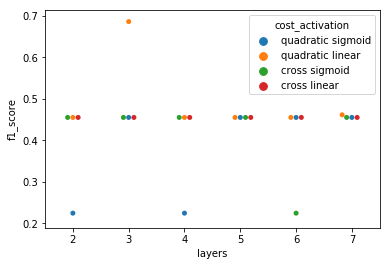

In [77]:
df = pd.DataFrame(results)
df['f1_score']= df['f1_score'].astype(np.float64)
df['cost_activation']=df['cost'] + " "+ df['activation'] 
sns.swarmplot(data=df, y='f1_score',x='layers', hue='cost_activation')

As you can see in the above plot, most of the parameterizations lead to around a 45.5% F-Score. There are a few with around 22% but there is a distint parameter with nearly 69% on there F-score! This parameter used a Quadratic function with a linear activation and 3 layers. We can observe from the plot above that the addition of hidden layers does not increase the performance. 

### Gradient Magnitude Visualization

In [95]:
params = dict(n_hidden=30, 
              n_hidden_layers=3,
              C=0.1, # tradeoff L2 regularizer
              epochs=10, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              cost_function='quadratic',
              activation_method='linear')

In [96]:
%%time 
nn = MultiLayerPerceptron(**params)
nn.fit(X_train, y_train, print_progress=10)
yhat = nn.predict(X_test)
print('Test acc:',accuracy_score(y_test,yhat))
sample_weights = [1.5,1.0,2.0,2.5]
weights = [sample_weights[x] for x in y_test ]
print('F1 acc: ', f1_score(y_test,yhat,average='weighted', sample_weight=weights) )

Epoch: 10/10

Test acc: 0.6631609229757599
F1 acc:  0.6865919602019581
Wall time: 10.1 s


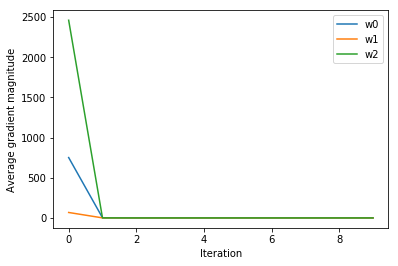

In [97]:
ax = plt.subplot(1,1,1)
for i in range(0,params['n_hidden_layers']):
    plt.plot(np.abs(nn.gradients_[i]), label='w' + str(i) )
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

The above plot shows the average gradient magnitude versus the number of training iterations for my most optimial parameters: 3-layers, quadratic cost function, and linear activation. We can easily see that the magnitude of the gradient start at much different values and rapidly approaches 0. After only a single iteration, the gradients in all 3 layers converge.